# Connectome analysis for the wing motor neurons
In this notebook the wing motor neurons of *Drosophila melanogaster* are searched for in the MANC connectome dataset. Pre- and postsynaptic neurons are gathered to analyze connections between the motorneurons as well as how many pre- and postsynaptic partners they have in common.

In the dataset, 'weight' stands for the total synapse count of the connection (see v1.0_manc-traced-adjacencies-v1.0_README file).

Following abbreviations are used in the dataset (Marin et al. (2023, preprint) - Systematic annotation of a complete adult male Drosophila nerve cord connectome reveals principles of functional organisation):
* 'IN' - intrinsic neurons (do not leave or enter the VNC towards/coming from the brain)
* 'AN' - ascending neuron
* 'DN' - descending neuron
* 'EN' - efferent neuron
* 'EA' - efferent ascending neuron
* 'MN' - motor neuron

Author: Bjarne Schultze <br>
last modified: 01.12.2023

## Quick overview of the wing motor neuron functions in song production 
**Three groups by activation pattern during pulse song:**
* b1 and b2 silent (also during sine)
* hg1-4, i2 always active
* i2, iii3-4 'bi-stable'/trial dependent
* b3 (activity on the non-active wing side), iii1 (intermediate correlation)

**Effect of silencing**
* silencing of tpn MN leads to loss of courtship song, silencing of tp1 and tp2 MNs results in reduced probability for courtship song
    * tpn MN silencing induces hanging wings (also partially for tp2 MN or tp2 MN + tp1 MN silencing)
    * silencing of all other MN did not change amout of song 
* silencing of hg1 and hg2 reduces sine song and therefore sine-to-pulse ratio
    * remining sine has higher carrier frequency (hg1 silenced)


* i2, hg1-2, tp1-2, tpn and tt affect pulse amout
* i2, hg1-2, ps1, tp1, tt, and dlm affect pulse structure
    * hg1, tp1, tt, and dlm silencing decreases pulse amplitude
    * i2, ps1, tt or dlm silencing leads to decreased pulse carrier frequency
    * i2 or hg1-2 silencing increases IPI
    * i2, hg1, hg2, ps1, tp1, tt, and dlm silencing increases amout of polycyclic pulses
* hg1-2, tpn and tt affect sine amout
* hg1 affects sine structure


**Proposed functions in courtship song:**
* b3 wing laterality
* tp1-2 tonic tension, (tp2 pulse start)
* i1-2 pulse length
* ps1 pulse frequency
* hgs pulse and sine structure + amount
* tt and dlms pulse amplitude

**Reference**
O’Sullivan, A., Lindsay, T., Prudnikova, A., Erdi, B., Dickinson, M., and von Philipsborn, A. C. (2018). Multifunctional Wing Motor Control of Song and Flight. *Curr. Biol.* 28, 2705-2717.e4. doi:10.1016/j.cub.2018.06.038.

*Note:*
The two  two tergopleural muscles tp1 and tp2 are innervated by the respective motor neurons as well as the tpn MN (innervates both tps in ca. 28 % of the cases, otherwise only tp2).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import nan

import connectome_fun as cfun

In [2]:
neuron_props = pd.read_pickle("neuron_prop_table.pkl")

In [3]:
# Load the neuron properties table
all_neuron_props = pd.read_feather('MANC\dat\manc-v1.0-neuron-properties.feather')
# Load the connections table
connections_all = pd.read_csv('MANC\dat\manc-traced-adjacencies-v1.0\\traced-connections.csv')
# Reduce connections table to connections with weights above a threshold
conn_threshold = 10
connections = connections_all[connections_all["weight"] > conn_threshold].reset_index()

# Try to load the neuoron data from a previous session
try:
    # Load the neuron ID dict with ID:type pairs
    neuron_ID_dict = np.load('./neuron_ID_dict.npy', allow_pickle=True).item()
    # Load the neuron property table containing all wing motor neurons and potential song circuit neurons
    neuron_props = pd.read_pickle('./neuron_prop_table.pkl')
except FileNotFoundError:
    print('The file(s) neuron_ID_dict.npy and/or neuron_prop_table.pkl could not be loaded. The content will be created again. ')
    success_load = False

#### Find wing motor neurons and the song circuit neurons in the dataset
List of neuorns from: <br> 
O’Sullivan, A., Lindsay, T., Prudnikova, A., Erdi, B., Dickinson, M., & Von Philipsborn, A. (2018). Multifunctional Wing Motor Control of Song and Flight. *Current Biology*, 28(17), 2705-2717.e4. https://doi.org/10.1016/j.cub.2018.06.038

EM IDs for the song circuit neurons from (especially vPR6, TN1a, dPR1): <br>
Lillvis, J. L., Wang, K., Shiozaki, H. M., Xu, M., Stern, D. L., and Dickson, B. J. (2023). The Neural Basis of Drosophila Courtship Song. *bioRxiv*, 2023.08.30.555537. Available at: https://doi.org/10.1101/2023.08.30.555537

In [6]:
# Search for neurons if no data from a previous session could be loaded
if not success_load:
    # List of wing motorneurons
    motor_neurons = ["b1 MN","b2 MN","b3 MN","i1 MN","i2 MN","iii1 MN","iii3 MN","iii4 MN","hg1 MN","hg2 MN","hg3 MN","hg4 MN",
                     "ps1 MN","tp1 MN","tp2 MN","tpn MN","TTMn","DLMn a b","DLMn c-f","pIP10"]
    # Find and index the entries with suitable names
    find_MN = all_neuron_props["type"].isin(motor_neurons)
    mn_props = all_neuron_props[find_MN].reset_index()

    # Display a message stating whether all neurons were found or not
    print(f"{len(mn_props['type'].unique())}/{len(motor_neurons)} requested neurons were found.")
    if len(mn_props['type'].unique()) < len(motor_neurons):
        print(f"The following neuron(s) was/were not found: {set(motor_neurons).difference(set(mn_props['type']))}")

    # List of song circuit neuron IDs (Lillvis et al. (2023, preprint))
    dpr1 = [10267, 10300]
    vpr6 = [13748, 13602, 14858, 14592, 14119, 14133, 13715]
    tn1a = [17640, 15521, 16113, 16465, 12883, 15148, 14581, 13945, 16207, 13928, 14779, 15936, 16042, 16391, 16690, 13155, 
            13445, 13514, 13727, 14277, 14375, 14401]

    # Find the song circuit neurons (SCNs) in the data set
    scn_neurons = cfun.flatten([dpr1,vpr6,tn1a])
    find_scn = all_neuron_props["bodyId"].isin(scn_neurons)
    scn_props = all_neuron_props[find_scn].reset_index()

    # Add the neuron type (according to Lillvis et al. (2023, preprint) to the data frame 
    scn_props.loc[scn_props["bodyId"].isin(dpr1), "type"] = "dPR1"
    scn_props.loc[scn_props["bodyId"].isin(vpr6), "type"] = "vPR6"
    scn_props.loc[scn_props["bodyId"].isin(tn1a), "type"] = "TN1a"
    # Update the neuron types in the big neuorn list
    all_neuron_props.loc[all_neuron_props["bodyId"].isin(dpr1), "type"] = "dPR1"
    all_neuron_props.loc[all_neuron_props["bodyId"].isin(vpr6), "type"] = "vPR6"
    all_neuron_props.loc[all_neuron_props["bodyId"].isin(tn1a), "type"] = "TN1a"

    # Add the SCNs to the neuron property data frame
    neuron_props = pd.concat([mn_props,scn_props])
    neuron_props.sort_values("type", ignore_index=True, inplace=True)

    # Create dictionary mapping bodyIDs and types to look them up easily
    neuron_ID_dict = dict(zip(all_neuron_props.bodyId.astype('int64'), all_neuron_props.type))
    # Save ID dict for later use
    np.save('./neuron_ID_dict',neuron_ID_dict)
    # Save neuron property table
    neuron_props.to_pickle("neuron_prop_table.pkl")
    # Print message
    print('Saved neuron property table and neuron ID dict to: neuron_prop_table.pkl and neuron_ID_dict.npy!')

19/20 requested neurons were found.
The following neuron(s) was/were not found: {'iii4 MN'}


#### Get the postsynaptic neurons for each motorneuron
Store the body IDs along with the types and the weights of the connections.

In [6]:
# Get the downstream neurons (downstream connections)
ds_neurons = cfun.find_connected(neuron_props["bodyId"], connections, "ds", neuron_ID_dict).sort_values("type", ignore_index=True)
# Get the downstream neurons collapsed by their type
ds_neuron_coll = cfun.find_connected(neuron_props["bodyId"], connections, "ds", neuron_ID_dict, collapse_by_type=True)
# Re-sort the neurons
ds_neuron_coll = ds_neuron_coll.loc[(16,21,7,2,0,1,3,5,6,8,9,10,11,12,13,14,15,17,18,19,20),].reset_index()

In [7]:
# Get the different neurotransmitter types present in the datset
neurotransmitters = neuron_props["predictedNt"].unique()
# Assign a color to each neurotranmitter
nt_color_dict = dict(zip(neurotransmitters,["lightseagreen", "black", "darkred", "darkgreen"]))
color_order_nt = [ nt_color_dict[nt] for nt in neuron_props["predictedNt"] ]

#### Visualize the connections between the neurons in a connectivity matrix

Notice that only connections with weights above 10 were considered!


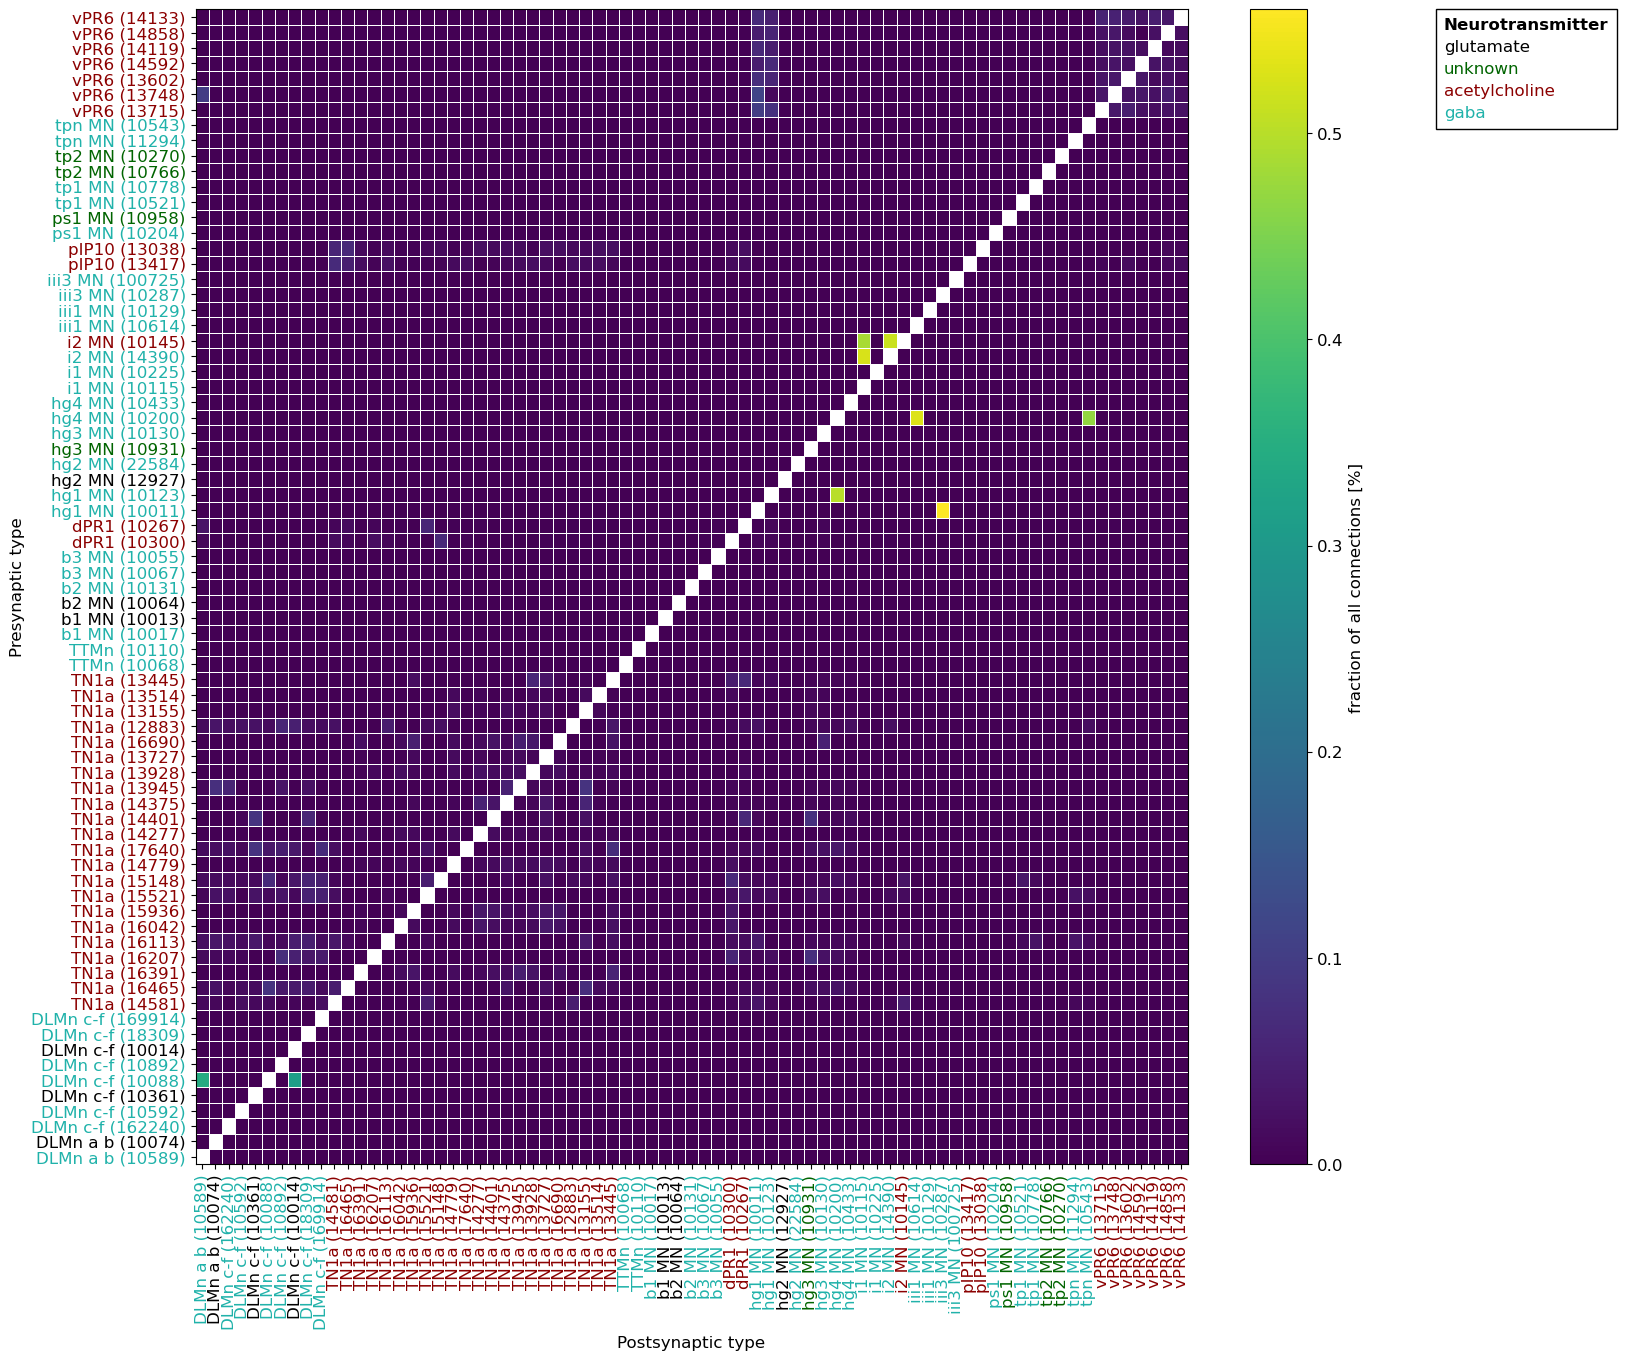

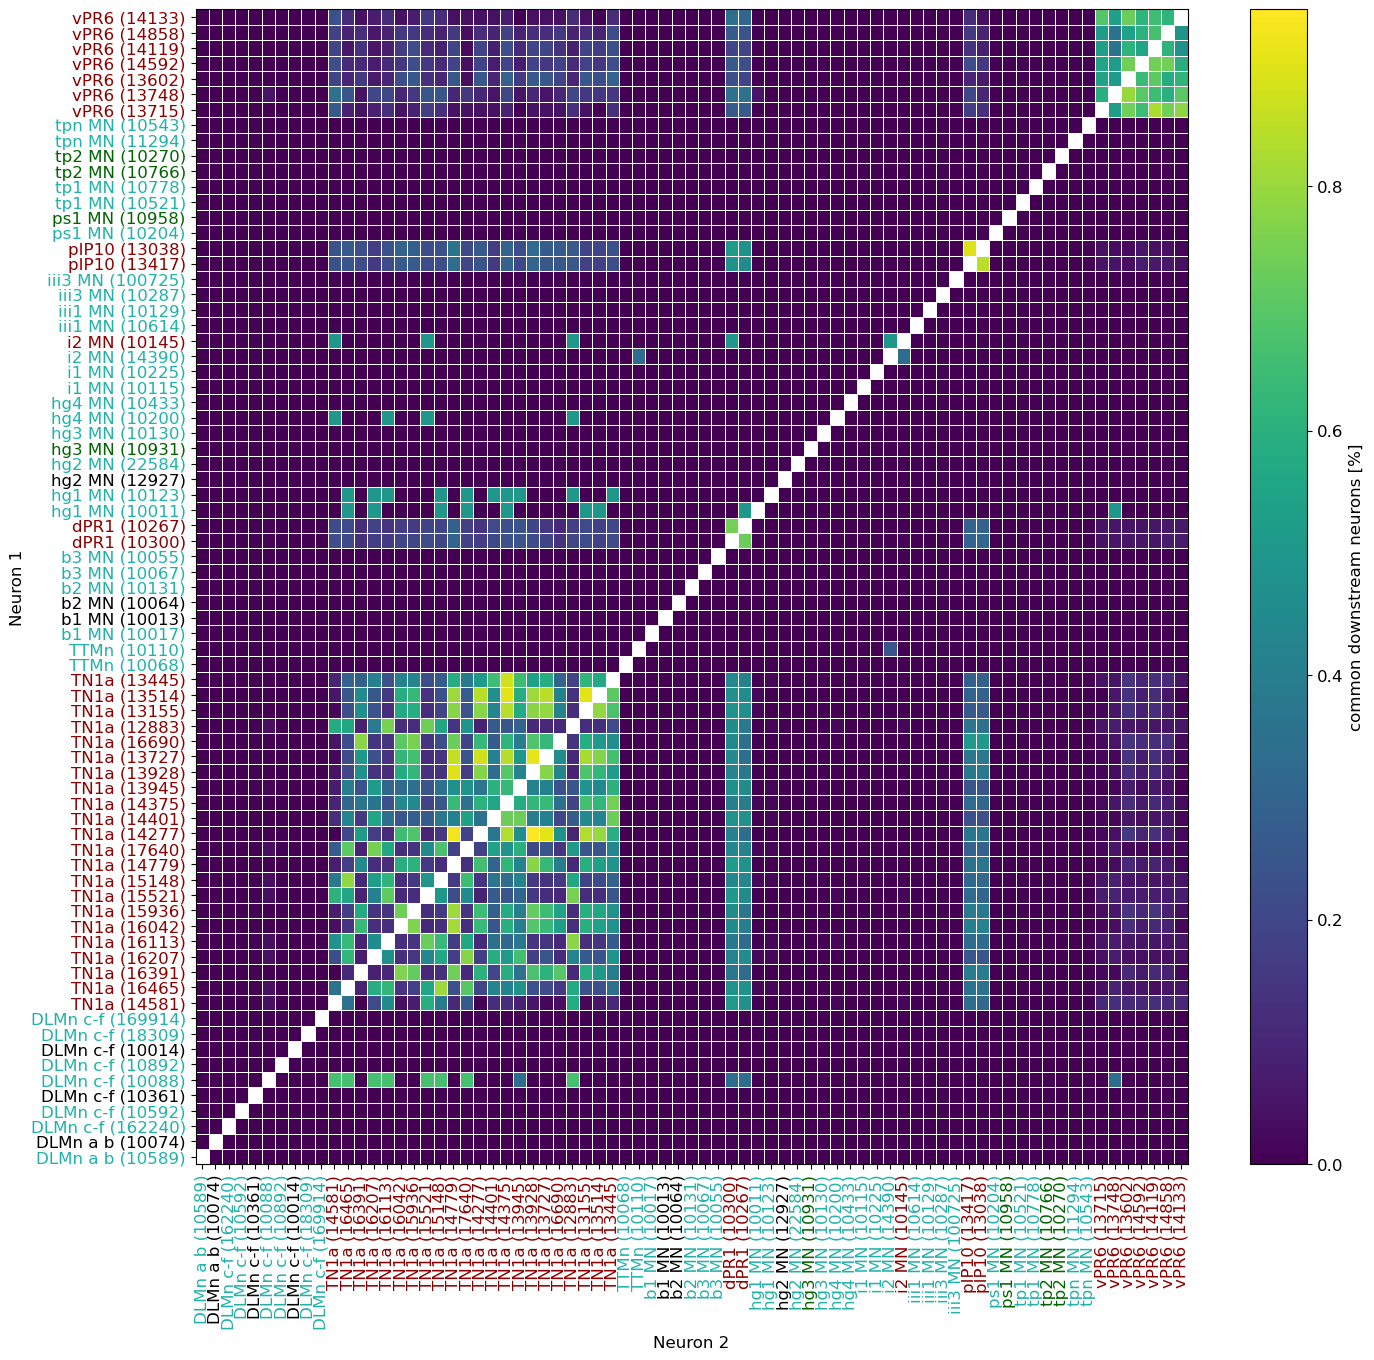

In [8]:
# Create empty matrices and a list to store the information
conn_matrix = np.zeros((len(ds_neurons),len(ds_neurons)))
conn_matrix_dsn = np.zeros((len(ds_neurons),len(ds_neurons)))
common_dsn = []

# Iterate over all neurons
for cell in range(len(ds_neurons)):
    # Search for MN neurons in the downstream neurons
    conn_index = np.isin(ds_neurons.loc[cell,"conn_bodyId"],ds_neurons["bodyId"])
    # Find indices where to store the number of connection in conn_matrix
    paste_index = ds_neurons["bodyId"].isin(ds_neurons.loc[cell, "conn_bodyId"][conn_index])
    # Fill the connectivity matrix
    conn_matrix[cell, paste_index] = ds_neurons.loc[cell, "conn_weight"][conn_index]

    # Find the intersection in the donwstream neuron body IDs between the current and all other neurons
    all_dsn = ds_neurons.loc[cell,"conn_bodyId"]
    dsn = [ list(set(all_dsn) & set(ds_neurons.loc[cell_2,"conn_bodyId"])) for cell_2 in range(len(ds_neurons)) ]
    # Append list of common downstream neurons of the current neuron
    common_dsn.append(dsn)
    # Fill the matirx with the numbers of the common downstream neurons
    conn_matrix_dsn[cell,:] = [ len(dsn[i])/len(all_dsn) if len(all_dsn) > 0 else 0 for i in range(len(dsn)) ]


# Fill the diagonal with nan 
np.fill_diagonal(conn_matrix, nan)
np.fill_diagonal(conn_matrix_dsn, nan)
# Set the color for 'bad" values (nan) to white
cmap = plt.cm.viridis
cmap.set_bad((1, 1, 1, 1))

# Plot the connectivity matrices
plt.style.use('plotstyle_bjarne.mplstyle')
figl, axl = plt.subplots(1,1, figsize=(16,15))
figr, axr = plt.subplots(1,1, figsize=(16,15))
pcm1 = axl.pcolormesh(conn_matrix, cmap=cmap, edgecolors="w", linewidth=0.5)
figl.colorbar(pcm1, ax=axl, label="fraction of all connections [%]")
pcm2 = axr.pcolormesh(conn_matrix_dsn, cmap=cmap, edgecolors="w", linewidth=0.5)
figr.colorbar(pcm2, ax=axr, label="common downstream neurons [%]")

# Adjust labelling
xy_labels = [ f"{ds_neurons.loc[i,'type']} ({ds_neurons.loc[i,'bodyId']})" for i in range(len(ds_neurons))]
xy_ticks = np.arange(0.5,len(ds_neurons)+0.5,1)
axl.set_xticks(xy_ticks, xy_labels, rotation=90)
axl.set_yticks(xy_ticks, xy_labels)
axl.set_xlabel("Postsynaptic type")
axl.set_ylabel("Presynaptic type")
# axl.set_title("Connectivity matrix - connections")
axr.set_xticks(xy_ticks, xy_labels, rotation=90)
axr.set_yticks(xy_ticks, xy_labels)
axr.set_xlabel("Neuron 2")
axr.set_ylabel("Neuron 1")
# axr.set_title("Connectivity matrix - common downstream neurons")

# Color the axes ticklabels according to the neurotransmitter type and add a legend
cfun.ax_colorcode(axl, color_order_nt, nt_color_dict.keys(), c_title="Neurotransmitter")
cfun.ax_colorcode(axr, color_order_nt, nt_color_dict.keys(), legend=False, c_title="Neurotransmitter")

# Print a note about the criterion that was applied to the connection weights
print(f"Notice that only connections with weights above {conn_threshold} were considered!")

# Save the figure
figl.savefig('./Report/figures/conn_matrix_all.eps', bbox_inches='tight')
figr.savefig('./Report/figures/conn_matrix_cdsn_all.eps', bbox_inches='tight')

#### Reduce the connectivity matrix to neuron types

Notice that only connections with weights above 10 were considered!


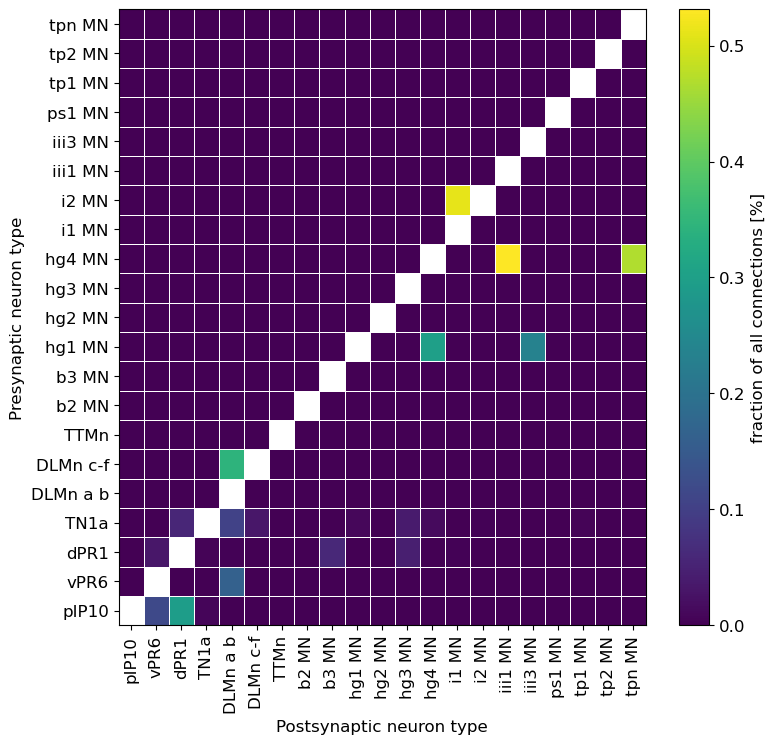

In [9]:
# Create empty matrices and a list to store the information
conn_matrix_coll = np.zeros((len(ds_neuron_coll),len(ds_neuron_coll)))

# Iterate over all neurons
for cell in range(len(ds_neuron_coll)):
    # Search for MN neurons in the downstream neurons
    conn_index = np.isin(ds_neuron_coll.loc[cell,"conn_type"], ds_neuron_coll["type"])
    # Find indices where to store the number of connection in conn_matrix
    paste_index = ds_neuron_coll["type"].isin(ds_neuron_coll.loc[cell, "conn_type"][conn_index])
    # Fill the connectivity matrix
    conn_matrix_coll[cell, paste_index] = [ ds_neuron_coll.loc[cell, "conn_weight"][i] for i,e in enumerate(conn_index) if e ]

# Fill the diagonal with nan 
np.fill_diagonal(conn_matrix_coll, nan)
# Set the color for 'bad" values (nan) to white
cmap = plt.cm.viridis
cmap.set_bad((1, 1, 1, 1))

# Plot the connectivity matrices
plt.style.use('plotstyle_bjarne.mplstyle')
fig, ax2 = plt.subplots(1,1, figsize=(8.5,8))
pcm1 = ax2.pcolormesh(conn_matrix_coll, cmap=cmap, edgecolors="w", linewidth=0.5)
fig.colorbar(pcm1, ax=ax2, label="fraction of all connections [%]")

# Adjust labelling
xy_labels = [ ds_neuron_coll.loc[i,'type'] for i in range(len(ds_neuron_coll))]
xy_ticks = np.arange(0.5,len(ds_neuron_coll)+0.5,1)
ax2.set_xticks(xy_ticks, xy_labels, rotation=90)
ax2.set_yticks(xy_ticks, xy_labels)
ax2.set_xlabel("Postsynaptic neuron type")
ax2.set_ylabel("Presynaptic neuron type")
# ax2.set_title("Connectivity matrix - connections (collapsed by type)")

# Print a note about the criterion that was applied to the connection weights
print(f"Notice that only connections with weights above {conn_threshold} were considered!")

# Save the figure
# fig.savefig('./Report/figures/conn_matrix.eps', bbox_inches='tight')

#### Find and visualize the common upstream neurons

Notice that only connections with weights above 10 were considered!


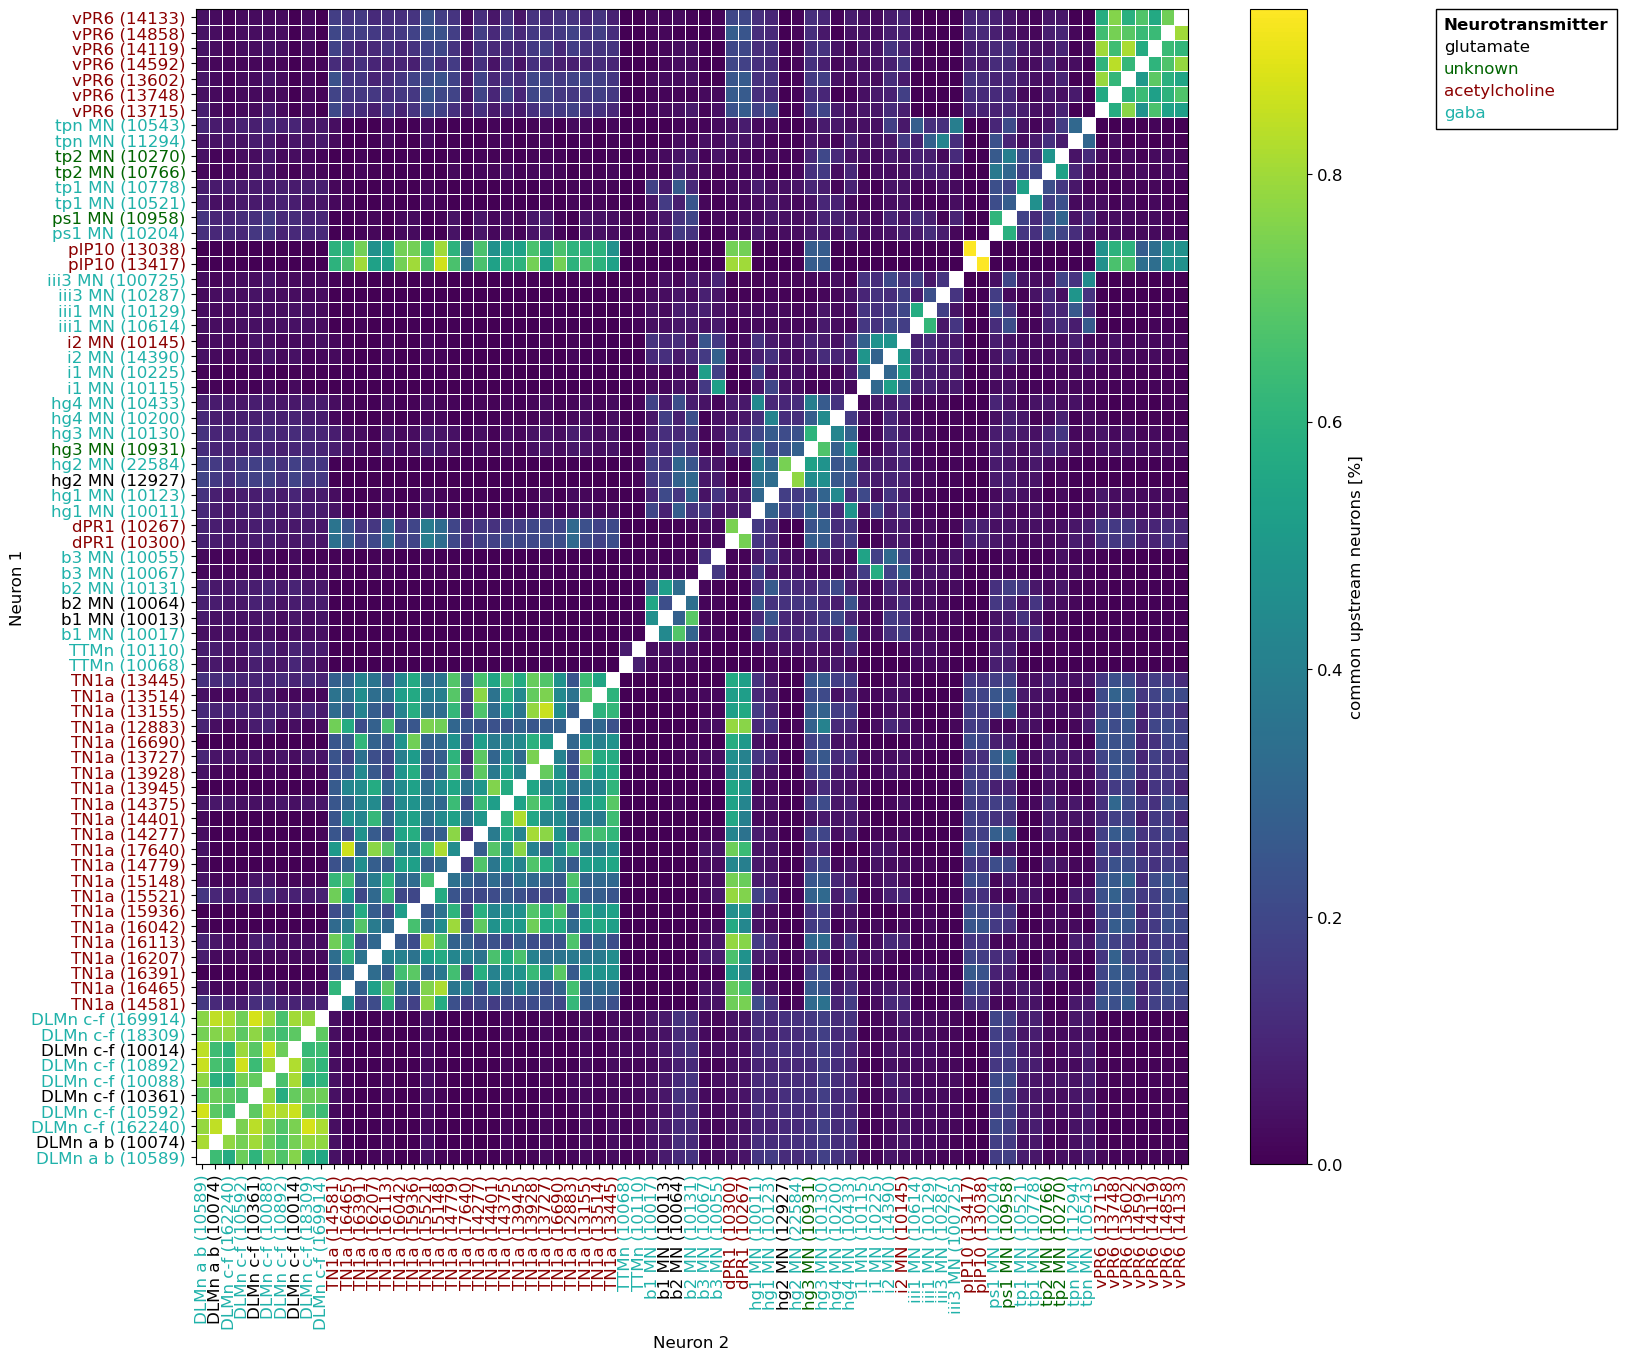

In [10]:
# Find the upstream connections
us_neurons = cfun.find_connected(neuron_props["bodyId"], connections, "us", neuron_ID_dict).sort_values("type", ignore_index=True)

# Create empty matrices and a list to store the information
conn_matrix_usn = np.zeros((len(us_neurons),len(us_neurons)))
common_usn = []

# Iterate over all neurons
for cell in range(len(us_neurons)):
    all_usn = us_neurons.loc[cell,"conn_bodyId"]
    # Find the intersection in the upstream neuron body IDs between the current and all other neurons
    usn = [ list(set(all_usn).intersection(set(us_neurons.loc[cell_2,"conn_bodyId"]))) for cell_2 in range(len(us_neurons)) ]
    # Append list of common upstream neurons of the current neuron
    common_usn.append(usn)
    # Fill the matirx with the numbers of the common upstream neurons
    conn_matrix_usn[cell,:] = [ len(usn[i])/len(all_usn) for i in range(len(usn)) ]

# Fill the diagonal with nan 
np.fill_diagonal(conn_matrix_usn, nan)
# Set the color for 'bad' values (nan) to white
cmap = plt.cm.viridis
cmap.set_bad((1, 1, 1, 1))

# Plot the connectivity matrices
fig2, ax3 = plt.subplots(figsize=(16,15))
pcm3 = ax3.pcolormesh(conn_matrix_usn, cmap=cmap, edgecolors="w", linewidth=0.5)
fig2.colorbar(pcm3, ax=ax3, label="common upstream neurons [%]")

# Adjust labelling
xy_labels = [ f"{us_neurons.loc[i,'type']} ({us_neurons.loc[i,'bodyId']})" for i in range(len(us_neurons))]
xy_ticks = np.arange(0.5,len(us_neurons)+0.5,1)
ax3.set_xticks(xy_ticks, xy_labels, rotation=90)
ax3.set_yticks(xy_ticks, xy_labels)
ax3.set_xlabel("Neuron 2")
ax3.set_ylabel("Neuron 1")
# ax3.set_title("Connectivity matrix - common upstream neurons")

# Color the axes ticklabels according to the neurotransmitter type and add a legend
cfun.ax_colorcode(ax3, color_order_nt, nt_color_dict.keys(), c_title="Neurotransmitter")

# Print a note about the criterion that was applied to the connection weights
print(f"Notice that only connections with weights above {conn_threshold} were considered!")

# Save the figure
# fig2.savefig('./Report/figures/conn_matrix_cusn_all.eps', bbox_inches='tight')

Notice that only connections with weights above 10 were considered!


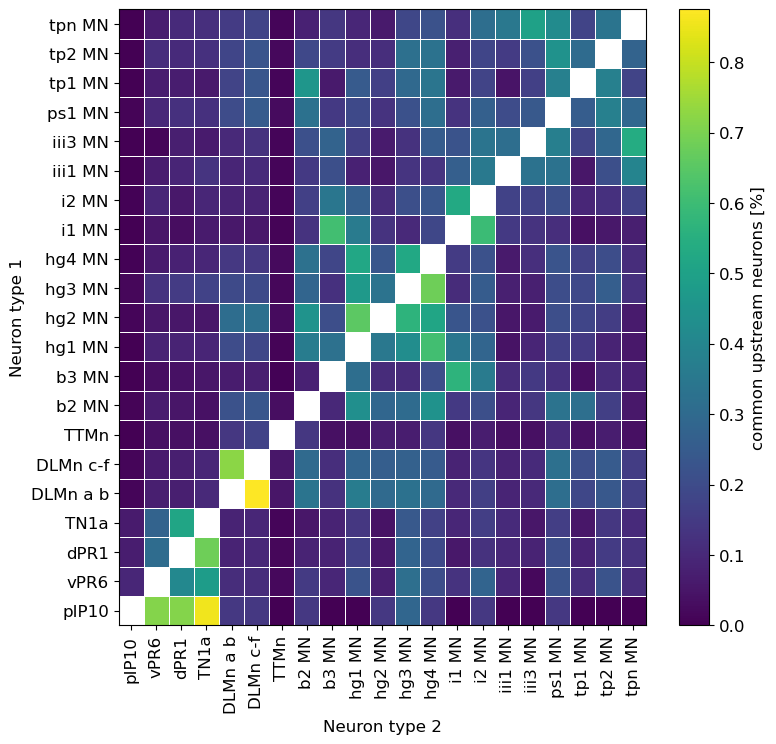

In [11]:
# Find the upstream connections
us_neuron_coll = cfun.find_connected(neuron_props["bodyId"], connections, "us", neuron_ID_dict, collapse_by_type=True)
us_neuron_coll = us_neuron_coll.loc[(16,21,7,2,0,1,3,5,6,8,9,10,11,12,13,14,15,17,18,19,20),].reset_index()

# Create empty matrices and a list to store the information
conn_matrix_us_coll = np.zeros((len(us_neuron_coll),len(us_neuron_coll)))
common_usn_coll = []

# Iterate over all neurons
for cell in range(len(us_neuron_coll)):
    all_usn = us_neuron_coll.loc[cell,"conn_type"]
    # Find the intersection in the upstream neuron body IDs between the current and all other neurons
    usn = [ list(set(all_usn).intersection(set(us_neuron_coll.loc[cell_2,"conn_type"]))) for cell_2 in range(len(us_neuron_coll)) ]
    # Append list of common upstream neurons of the current neuron
    common_usn_coll.append(usn)
    # Fill the matirx with the numbers of the common upstream neurons
    conn_matrix_us_coll[cell,:] = [ len(usn[i])/len(all_usn) for i in range(len(usn)) ]

# Fill the diagonal with nan 
np.fill_diagonal(conn_matrix_us_coll, nan)
# Set the color for 'bad' values (nan) to white
cmap = plt.cm.viridis
cmap.set_bad((1, 1, 1, 1))

# Plot the connectivity matrices
fig2, ax4 = plt.subplots(figsize=(8.5,8))
pcm3 = ax4.pcolormesh(conn_matrix_us_coll, cmap=cmap, edgecolors="w", linewidth=0.5)
fig2.colorbar(pcm3, ax=ax4, label="common upstream neurons [%]")

# Adjust labelling
xy_labels = [ us_neuron_coll.loc[i,'type'] for i in range(len(us_neuron_coll))]
xy_ticks = np.arange(0.5,len(us_neuron_coll)+0.5,1)
ax4.set_xticks(xy_ticks, xy_labels, rotation=90)
ax4.set_yticks(xy_ticks, xy_labels)
ax4.set_xlabel("Neuron type 2")
ax4.set_ylabel("Neuron type 1")
# ax4.set_title("Connectivity matrix - common upstream neurons (collapsed by type)")

# Print a note about the criterion that was applied to the connection weights
print(f"Notice that only connections with weights above {conn_threshold} were considered!")

# Save the figure 
# fig2.savefig('./Report/figures/conn_matrix_upstream.eps', bbox_inches='tight')